### 

In [1]:
from qiskit import QuantumCircuit, Aer, execute, transpile
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd

from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.quantum_info.operators import Operator, Pauli

In [150]:
M=[[1,2],[1,2]]
array_to_latex(M)


<IPython.core.display.Latex object>

### Building the Sparsed Unitary Matrix $S_A$ from matrix A 

$$S_A = \sum_{j, k = 1}^{N} A_{jk}|k\rangle \langle j|\otimes |j\rangle \langle k| $$

Here input data such as text, picture, audio etc is transformed into the form of matrix A. This $S_A$ matrix is one-sparse in a quadratically bigger space and reduces to the usual swap matrix for $A_{jk} = 1$ and
j,k = 1, . . . ,N.

Link to Original Paper : <a>https://journals.aps.org/pra/pdf/10.1103/PhysRevA.97.012327<a/>

In [139]:
    
def Multiply(A,B):              # A,B are array gives tensor product
    X=list(A[0]*B)              # multiply 0th term of A with all term of B and store it in X
    for i in range(1,len(A)):   
        X = X + list(A[i]*B)    # Loop concatenates/inserts next terms like 1st term of A multiplied by B in same X
    return X    
        
def rowmatrix(y,t):           # Creates <y| bra row term, here y is integer, we create computational basis 
    import numpy as np        # same procepure as above but don't do transpose at last, this will keep row form
    x1=[]
    Zero = np.array([1,0])
    One = np.array([0,1])
    if y==0:
        x1.append(y)
    while y != 0:
        x1.append(y%2)
        y = y//2 
    while len(x1)!= t:
        x1.append(0)
            
    x1.reverse()
    x2 = np.array(x1)
    if x2[0] == 0:
        A = Zero
        for i in range(1,len(x2)):
            if x2[i] == 0:
                A = Multiply(A,Zero)
            elif x2[i] == 1:
                A = Multiply(A,One)
        
    elif x2[0] == 1:
        A = One
        for i in range(1,len(x2)):
            if x2[i] == 0:
                A = Multiply(A,Zero)
            elif x2[i] == 1:
                A = Multiply(A,One)
    return np.matrix(A)         # the whole matrix (1D array) found using tensor product 

def columnmatrix(x,t):        # Creates |x> ket column term, here x is integer, we create computational basis 
    return rowmatrix(x,t).T     # make transpose of whole matrix (1D array) found using tensor product 

def tensor_kj_jk(P,Q):
    from sympy.physics.quantum import TensorProduct
    return TensorProduct(P,Q)

def sparsed_unitary_matrix(A):
    N = len(A)
    i=0
    while 2**i <= max(map(max, A)):
        i=i+1
    t = i 
    #print(t)
    #this t defines what should be the length of |x> in computational basis. 
    #SUM = np.matrix(np.zeros([N**2,N**2]))
    if t == 0:
        return A 
    else :
        SUM = tensor_kj_jk(columnmatrix(0,t)*rowmatrix(0,t), columnmatrix(0,t)*rowmatrix(0,t))*A[0][0]
        SUM = SUM + tensor_kj_jk(columnmatrix(1,t)*rowmatrix(0,t), columnmatrix(0,t)*rowmatrix(1,t))*A[0][1]
        SUM = SUM + tensor_kj_jk(columnmatrix(0,t)*rowmatrix(1,t), columnmatrix(1,t)*rowmatrix(0,t))*A[1][0]
    
        for k in range(1, N):
            for j in range(1, N):
                SUM += tensor_kj_jk(columnmatrix(k,t)*rowmatrix(j,t), columnmatrix(j,t)*rowmatrix(k,t))*A[j][k]
        return SUM   

### Testing for some matrices if codes are working or not...

In [140]:
Y = sparsed_unitary_matrix([[1,1],
                        [1,1]])
Y

matrix([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])

In [141]:
from qiskit.quantum_info.operators import Operator

Mat = Operator(Y)
Mat.is_unitary()

True

### Quantum Phase Estimation Part (Feature Encoding Part)

In [142]:
"""-------------Quantum Fourier Transform---------------"""

def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

"""-------------Inverse Quantum Fourier Transform---------------"""

def qft_dagger(circuit, phase_register_size):
    """n-qubit QFTdagger the first n qubits in circ"""
    n = phase_register_size
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circuit.cp(-np.pi/float(2**(j-m)), m, j)
        circuit.h(j)
    return circuit

"""-------------Quantum Phase Estimation--------------"""

def qpe_circuit(register_size, angle):
    # Your code goes here
    
    phase_register_size = register_size
    qpe = QuantumCircuit(phase_register_size+1, phase_register_size)

    # Apply H-Gates to counting qubits:
    for qubit in range(phase_register_size):
        qpe.h(qubit)

    # Prepare our eigenstate |psi>:
    qpe.x(phase_register_size)

    # Do the controlled-U operations:
    angle = 2*np.pi*angle
    repetitions = 1
    for counting_qubit in range(phase_register_size):
        for i in range(repetitions):
            qpe.cp(angle, counting_qubit, phase_register_size);
        repetitions *= 2

    # Measure of course!
    qpe.barrier()

    qft_dagger(qpe, phase_register_size)

    for n in range(phase_register_size):
        qpe.measure(n,n)
        
    return qpe
    
        

### Checking...


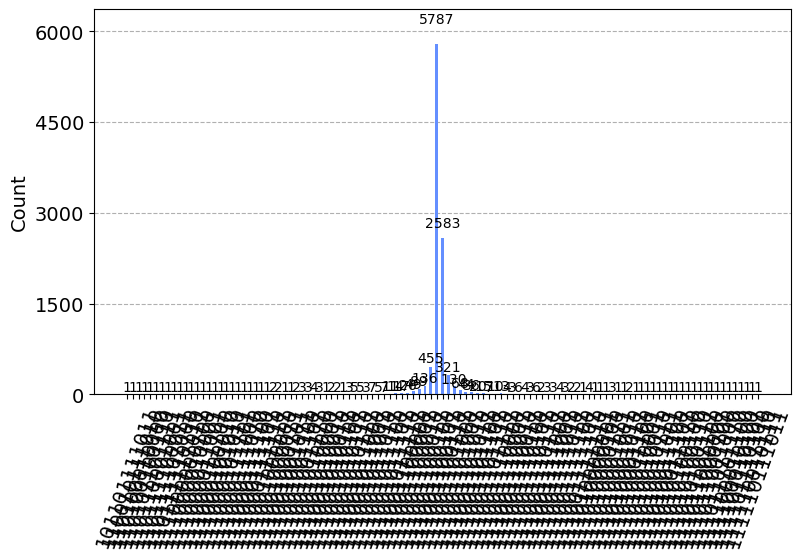

In [151]:
reg_size = 12 

qpe_check = qpe_circuit(reg_size, 0.9)
sim =  Aer.get_backend('aer_simulator')
shots = 10000
count_qpe = execute(qpe_check, sim, shots=shots).result().get_counts()
plot_histogram(count_qpe, figsize=(9,5))

In [152]:
max_binary_counts = 0
max_binary_val = ''
for key, item in count_qpe.items():
    if item > max_binary_counts:
        max_binary_counts = item
        max_binary_val = key
## function to convert a binary string to decimal goes here
def binary_to_decimal(y):
    x=0
    for i in range(len(y)):
        x=x+int(y[i])/2**(i+1)
    return x


estimated_phase = binary_to_decimal(max_binary_val) # calculate the estimated phase

print("Original_phase = ",0.9)
print("estimated_phase = ",estimated_phase)

Original_phase =  0.9
estimated_phase =  0.89990234375
